<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>

# Neural Network Framework (Keras)

## *Data Science Unit 4 Sprint 2 Assignmnet 3*

## Use the Keras Library to build a Multi-Layer Perceptron Model on the Boston Housing dataset

[X] The Boston Housing dataset comes with the Keras library so use Keras to import it into your notebook. 

[X] Normalize the data (all features should have roughly the same scale)

[X] Import the type of model and layers that you will need from Keras.

[X] Instantiate a model object and use `model.add()` to add layers to your model

[X] Since this is a regression model you will have a single output node in the final layer.

[X] Use activation functions that are appropriate for this task

[X] Compile your model

[X] Fit your model and report its accuracy in terms of Mean Squared Error

[X] Use the history object that is returned from model.fit to make graphs of the model's loss or train/validation accuracies by epoch. 

[X] Run this same data through a linear regression model. Which achieves higher accuracy?

[] Do a little bit of feature engineering and see how that affects your neural network model. (you will need to change your model to accept more inputs)

[] After feature engineering, which model sees a greater accuracy boost due to the new features?

In [1]:
import tensorflow as tf

In [2]:
# importing the bosting dataset
from tensorflow.keras.models import Sequential
from tensorflow.keras.datasets import boston_housing
from tensorflow.keras.layers import Dense

(X_train, y_train), (X_test, y_test) = boston_housing.load_data()

In [3]:
X_train = tf.keras.utils.normalize(X_train)
X_test = tf.keras.utils.normalize(X_test)

In [4]:
X_train

array([[2.41189924e-03, 0.00000000e+00, 1.59296858e-02, ...,
        4.10962409e-02, 7.76718953e-01, 3.66343633e-02],
       [4.07923050e-05, 1.54587284e-01, 3.80378407e-03, ...,
        2.75446433e-02, 7.40857215e-01, 5.82747215e-03],
       [6.34505528e-03, 0.00000000e+00, 2.34463745e-02, ...,
        2.61666721e-02, 4.86441025e-01, 4.22293817e-03],
       ...,
       [7.29281484e-05, 7.36435428e-02, 1.27508534e-02, ...,
        3.55593107e-02, 7.62210668e-01, 1.64751126e-02],
       [4.37205159e-03, 0.00000000e+00, 3.98313637e-02, ...,
        2.99040371e-02, 5.32881804e-01, 3.21214113e-02],
       [3.09311543e-05, 1.28969372e-01, 6.29800433e-03, ...,
        3.35320367e-02, 8.09712706e-01, 9.41476414e-03]])

In [5]:
# normalizing data
print(X_train.shape,
      y_train.shape,
      X_test.shape,
      y_test.shape)

(404, 13) (404,) (102, 13) (102,)


In [6]:
# model and layers needed from the Keras library
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# instantiating a model object
model = Sequential()

# adding an input layer
model.add(Dense(13, input_dim=13, kernel_initializer='normal', activation='relu', name='FirstHidden'))
model.add(Dense(30, activation='relu'))

# Adding an output layer
model.add(Dense(1, kernel_initializer='normal'))

# compiling model
model.compile(loss='mean_squared_error', optimizer='adam')

In [7]:
model.fit(X_train, y_train, epochs=150, verbose=False)

In [8]:
model.compile(loss='mean_squared_error', optimizer='adam',
              metrics=['mse'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
FirstHidden (Dense)          (None, 13)                182       
_________________________________________________________________
dense (Dense)                (None, 30)                420       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 31        
Total params: 633
Trainable params: 633
Non-trainable params: 0
_________________________________________________________________


In [9]:
model.fit(X_train, y_train, epochs=300, verbose=False)

In [10]:
scores = model.evaluate(X_test, y_test)
print(f"{model.metrics_names[1]}: {scores[1]}")

102/102 [==============================] - 0s 608us/sample - loss: 39.4498 - mse: 39.4498
mse: 39.44984436035156


In [11]:
fit = model.fit(X_train, y_train, epochs=300, validation_split=.1, verbose=False)
history = model.fit(X_train, y_train, epochs=100, verbose=False)

In [12]:
scores = model.evaluate(X_test, y_test)

102/102 [==============================] - 0s 55us/sample - loss: 27.4653 - mse: 27.4653


In [13]:
print(f'{model.metrics_names[1]}: {scores[1]}')

mse: 27.465255737304688


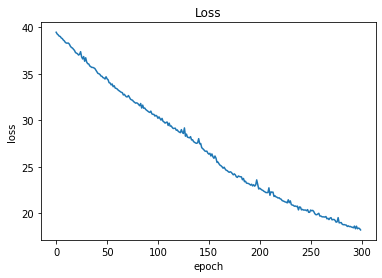

In [14]:
import matplotlib.pyplot as plt

plt.plot(fit.history['loss'])
plt.title("Loss")
plt.xlabel("epoch")
plt.ylabel('loss')
plt.show()

In [15]:
# simpler linear regression model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

linreg = LinearRegression()
linreg.fit(X_train, y_train)
linreg_pred = linreg.predict(X_test)
mean_squared_error(linreg_pred, y_test)

18.165510493496484

## Use the Keras Library to build an image recognition network using the Fashion-MNIST dataset (also comes with keras)

- Load and preprocess the image data similar to how we preprocessed the MNIST data in class.
- Make sure to one-hot encode your category labels
- Make sure to have your final layer have as many nodes as the number of classes that you want to predict.
- Try different hyperparameters. What is the highest accuracy that you are able to achieve.
- Use the history object that is returned from model.fit to make graphs of the model's loss or train/validation accuracies by epoch. 
- Remember that neural networks fall prey to randomness so you may need to run your model multiple times (or use Cross Validation) in order to tell if a change to a hyperparameter is truly producing better results.

In [22]:
from tensorflow.keras.datasets import fashion_mnist
from tensorflow import keras

num_classes = 10

(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [23]:
X_train.head()

AttributeError: 'numpy.ndarray' object has no attribute 'head'

In [17]:
# Reshape the data
X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)

# X Variable Types
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# Correct Encoding on Y
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# shapes after encoding
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((60000, 784), (60000, 10), (10000, 784), (10000, 10))

In [18]:
f_mnist_model = Sequential()

# Input => Hidden
f_mnist_model.add(Dense(16, input_dim=784, activation='relu'))
# Hidden
f_mnist_model.add(Dense(16, activation='relu'))
# Hidden
f_mnist_model.add(Dense(16, activation='relu'))
# Hidden
f_mnist_model.add(Dense(16, activation='relu'))
# Output
f_mnist_model.add(Dense(num_classes,activation='softmax'))

#Compile
f_mnist_model.compile(loss='categorical_crossentropy',
                    optimizer='adam',
                    metrics=['accuracy'])

f_mnist_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 16)                12560     
_________________________________________________________________
dense_3 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_4 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_5 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_6 (Dense)              (None, 10)                170       
Total params: 13,546
Trainable params: 13,546
Non-trainable params: 0
_________________________________________________________________


In [19]:
hist = f_mnist_model.fit(X_train, y_train, batch_size=100, epochs=20, verbose=False)
scores = f_mnist_model.evaluate(X_test, y_test)

10000/10000 [==============================] - 0s 38us/sample - loss: 0.4798 - accuracy: 0.8329


KeyError: 'val_acc'

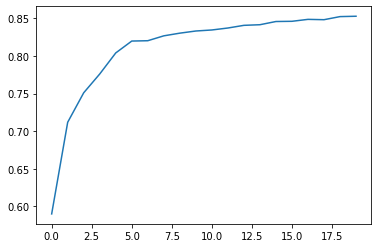

In [21]:
# plt.plot(hist.history['loss'])
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_acc'])
plt.title("Loss")
plt.xlabel("epoch")
plt.ylabel('loss')
plt.show()

## Stretch Goals:

- Use Hyperparameter Tuning to make the accuracy of your models as high as possible. (error as low as possible)
- Use Cross Validation techniques to get more consistent results with your model.
- Use GridSearchCV to try different combinations of hyperparameters. 
- Start looking into other types of Keras layers for CNNs and RNNs maybe try and build a CNN model for fashion-MNIST to see how the results compare.